In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
import dask.array as da
from dask.distributed import Client
from scipy.ndimage.filters import median_filter

import flika as flk
flk.start_flika()
from flika.window import Window as flw

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def get_klab_dataset(path):
    from glob import glob
    from fish.util.fileio import to_dask
    files = sorted(glob(path + 'TM*/*/*CM0*'))
    dsk = to_dask(files).squeeze().transpose(0,3,2,1)
    
    return dsk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [2]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/GliaNeuron/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
dset = ZDS(base_dir + 'raw/')

In [8]:
klab_data = get_klab_dataset('/nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/')

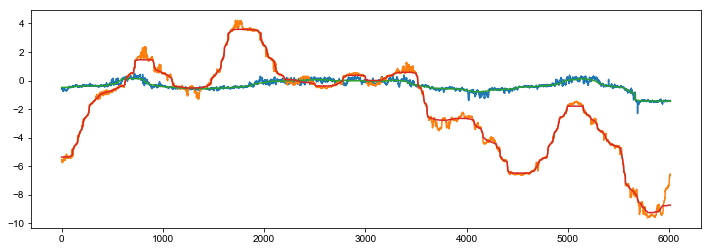

In [3]:
data = dset.data
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
reg_path = reg_dir + 'regparams_affine.npy'
fs_im = dset.metadata['volume_rate']
shifts = -np.load(reg_path)[:,:-1,-1]

fig, axs = plt.subplots(figsize=(12,4))
axs.plot(shifts)
shifts_filt = median_filter(shifts, size=(300,1))
axs.plot(shifts_filt)

In [4]:
data.shape

(6013, 22, 2048, 2048)

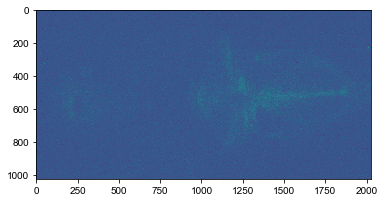

In [5]:
roi = slice(0,None), slice(16,17), slice(None,1024), slice(20,None)
crop=slice(None), slice(None), slice(10,-10), slice(10,-10)
sample = data[roi][-1].compute(scheduler='threads').squeeze()
plt.imshow(sample)

In [6]:
window_seconds = 300
window_frames = int(window_seconds * fs_im)
camera_baseline = 80

def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    percentile = 20
    downsample = 10;
    return baseline(v, window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    return (v / mybl(v).clip(1,None))

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)


In [7]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.12:37549 Dashboard: http://10.36.111.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
data_filt = data[roi].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts, dtype='float32')
rechunked = data_tx.rechunk((-1, 'auto', 'auto','auto'))

In [22]:
from fish.util.distributed import get_downsampled_baseline
from os.path import exists
from os import remove
ds_factors = [12, 24, 36, 48]
window = window_frames
perc=20
bl_fnames = [reg_dir + f'baseline_ds{ds}.h5' for ds in ds_factors]
compute_baselines = True

if compute_baselines:
    params = [get_downsampled_baseline(data_tx, factor=ds, window=window, perc=perc) for ds in ds_factors]
    cluster.start_workers(400)

    for ind, p in enumerate(params):
        fn = bl_fnames[ind]
        with File(fn, mode='a') as fh:
            try:
                fh['keyframes'] = p[0]
            except:
                fh['keyframes'][()] = p[0]
            dsb_ = p[1].compute()
            try:
                fh['baseline'][(slice(None), *roi[1:])] = dsb_
            except:
                fh.create_dataset('baseline', (len(p[0]), *data.shape[1:]))
                fh['baseline'][(slice(None), *roi[1:])] = dsb_

cluster.stop_all_jobs()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [10]:
# make some baselines 

In [24]:
cluster.start_workers(100)
errs = [] 
blfull_ = (rechunked[crop] - camera_baseline).map_blocks(mybl, dtype='float32').squeeze().compute()

for bl_fname in bl_fnames:
    bl_h5 = da.from_array(File(bl_fname, libver='latest', mode='r')['baseline'], chunks=data.chunksize).astype('float32')
    kf = File(bl_fname, mode='r')['keyframes'][:]
    dsb = InterpArray(kf, bl_h5, full_shape=data.shape, interpolation_axis=0)[roi].astype('float32')        
    
    blds_ = (dsb[crop] - camera_baseline).squeeze().compute()
    err = ((blds_ / blfull_) - 1)
    
    result = err.mean(0), err.max(0)
    errs.append(result)
    
cluster.stop_all_jobs()
errs = np.array(errs)

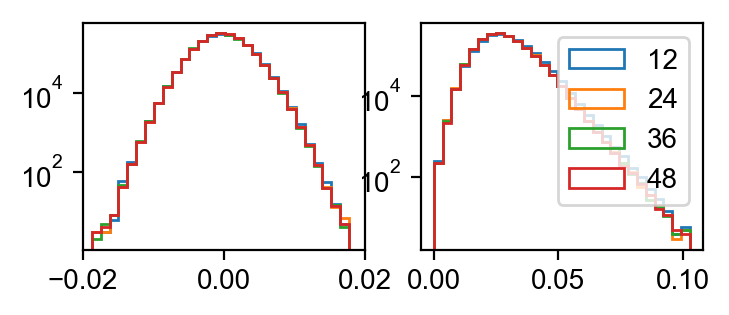

In [27]:
nbins = 30
bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)

fig, axs = plt.subplots(ncols=2, figsize=(4,1.5), dpi=200)

[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step') for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=ds_factors[ind]) for ind, err in enumerate(errs)];
axs[0].set_xlim(-.02,.02)
axs[1].legend()
[ax.semilogy() for ax in axs]
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_glia_plots.pdf')

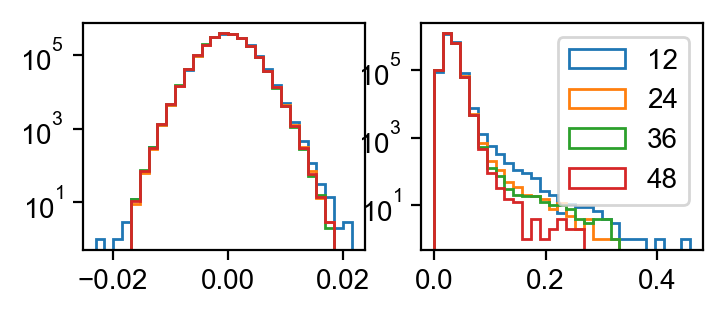

In [99]:
nbins = 30
bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)

fig, axs = plt.subplots(ncols=2, figsize=(4,1.5), dpi=200)

[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step') for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=ds_factors[ind]) for ind, err in enumerate(errs)];
axs[1].legend()
[ax.semilogy() for ax in axs]
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_neuron_plots.pdf')

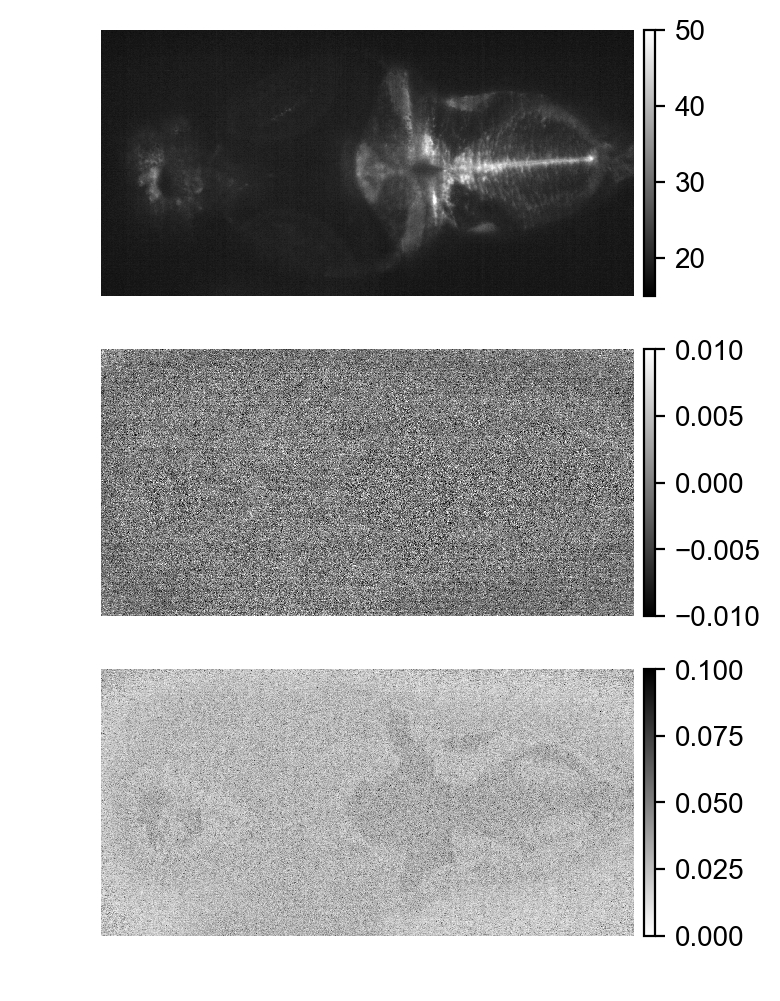

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(4,6),nrows=3, dpi=200)
axs[0].imshow(blfull_[0], cmap='gray', clim=(15,50))
axs[1].imshow(errs[-1,0], cmap='gray', clim=(-.01, .01))
axs[2].imshow(errs[-1,1], cmap='gray_r', clim=(0,.1))

for ax in axs:
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax)
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_error_glia_images.pdf')

In [26]:
def colorize_bins(bins, patches, cmap):
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))


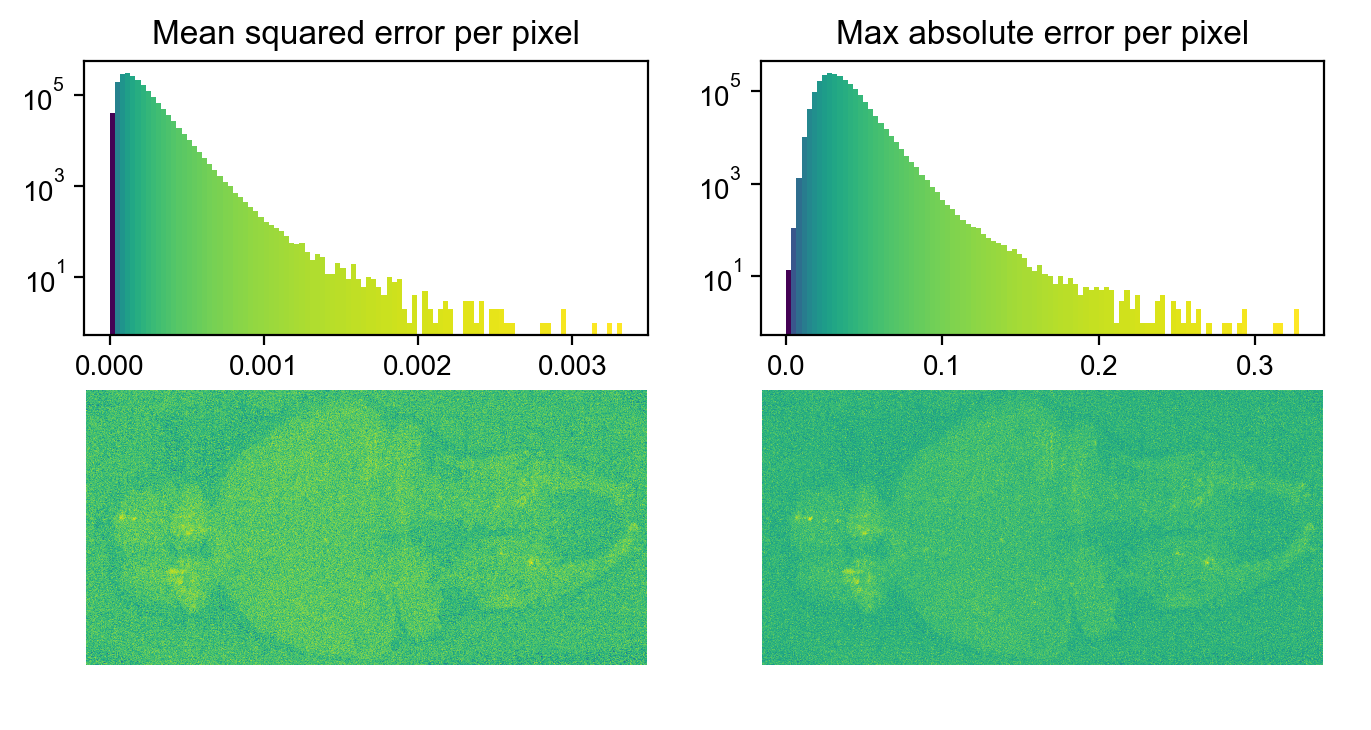

In [27]:
from matplotlib import cm
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(8,4), dpi=200)

axs[1,0].imshow(np.log(mse_result), cmap='viridis')
axs[1,0].axis('off')

axs[1,1].imshow(np.log(max_err_result), cmap='viridis')
axs[1,1].axis('off')

axs[0,0].title.set_text('Mean squared error per pixel')
_, bins, patches = axs[0,0].hist(mse_result.ravel(), 100);
colorize_bins(np.log(bins), patches, cm.viridis)
axs[0,0].semilogy();

axs[0,1].title.set_text('Max absolute error per pixel')
_, bins, patches = axs[0,1].hist(max_err_result.ravel(), 100);
colorize_bins(np.log(bins), patches, cm.viridis)
axs[0,1].semilogy();
